In [1]:
using PyCall

skdata = pyimport("sklearn.datasets")

cats = ["rec.autos", "rec.motorcycles",
        "sci.crypt","sci.electronics", 
        "sci.med", "sci.space",
        "talk.politics.guns", "talk.religion.misc",
        "rec.sport.baseball", "rec.sport.hockey"]

newsgroups = skdata.fetch_20newsgroups(subset = "all", categories = cats)

Dict{Any,Any} with 5 entries:
  "target_names" => ["rec.autos", "rec.motorcycles", "rec.sport.baseball", "rec…
  "data"         => ["From: kensib@cary112.its.rpi.edu (Brian C. Kensing)\nSubj…
  "filenames"    => PyObject array(['/home/psh/scikit_learn_data/20news_home/20…
  "target"       => [0, 6, 4, 6, 5, 7, 5, 2, 6, 1  …  8, 2, 3, 2, 0, 3, 9, 9, 4…
  "DESCR"        => ".. _20newsgroups_dataset:\n\nThe 20 newsgroups text datase…

In [2]:
py"""
import spacy
model = spacy.load("en")
discard = {'PUNCT','SPACE','SYM','NUM',
           'X','PRON','DET','PART','ADP'}

def tokenize(string):
    doc = model(string)
    words = []
    for w in doc:
      if w.pos_ not in discard and len(w.lemma_) > 1:
         words.append(w.lemma_ + "_" + w.pos_)
    return words
"""

In [3]:
tokenize = py"tokenize"
tokenize("""
spaCy excels at large-scale information extraction tasks.
It's written from the ground up in carefully memory-managed Cython.
""")

14-element Array{String,1}:
 "spacy_ADJ"       
 "excel_NOUN"      
 "large_ADJ"       
 "scale_NOUN"      
 "information_NOUN"
 "extraction_NOUN" 
 "task_NOUN"       
 "be_VERB"         
 "write_VERB"      
 "ground_NOUN"     
 "carefully_ADV"   
 "memory_NOUN"     
 "manage_VERB"     
 "cython_PROPN"    

In [4]:
sktext = pyimport("sklearn.feature_extraction.text")

vectorizer = sktext.CountVectorizer(
    lowercase = false,
    tokenizer = tokenize,
    min_df = 10, 
    max_df = 0.3)

@time counts = vectorizer.fit_transform(newsgroups["data"])

457.418519 seconds (50.46 k allocations: 2.219 MiB, 0.00% gc time)


PyObject <9469x11567 sparse matrix of type '<class 'numpy.int64'>'
	with 808236 stored elements in Compressed Sparse Row format>

In [5]:
using SparseArrays, LinearAlgebra, Gadfly
using BenchmarkTools: @btime
using Base.Threads: @threads
using Arpack: svds

In [6]:
function Base.convert(::Type{SparseMatrixCSC{T}}, A::PyObject) where T
    A = A.tocoo()
    sparse(A.row .+ 1, A.col .+ 1,
           convert(Vector{T}, A.data),
           A.shape...)
end

In [7]:
counts = convert(SparseMatrixCSC{Float32}, counts)

Dict(f=>getfield(counts, f) for f in fieldnames(typeof(counts)))

Dict{Symbol,Any} with 5 entries:
  :m      => 9469
  :rowval => [843, 971, 1043, 1144, 1646, 2078, 2569, 3054, 3281, 3431  …  7435…
  :n      => 11567
  :colptr => [1, 43, 95, 108, 122, 132, 144, 158, 178, 190  …  808054, 808070, …
  :nzval  => Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, …

$$
\begin{align}
tf_{i,j} &= \text{term frequency of term i in document j} \\
l_{i,j} &= \log(tf_{i,j} + 1) \\
\end{align}
$$

$$
\begin{align}
p_{i,j} &= \frac{tf_{i,j}}{ \sum_j tf_{i,j}} \\
g_i &= 1 + \frac{\sum_j p_{i,j}\log p_{i,j}}{\log(1 + \text{number of documents})} \\
\end{align}
$$

$$a_{i,j} = l_{i,j} \times g_i$$

In [8]:
function term_frequency(ps)
    total = sum(ps)
    (p / total for p in ps)
end

term_frequency (generic function with 1 method)

In [9]:
entropy(x) = x * log(x)

entropy (generic function with 1 method)

In [10]:
function global_weight(p, log_n_docs)
    g = sum(entropy, term_frequency(p))
    1 + g / log_n_docs
end

global_weight (generic function with 1 method)

In [11]:
n = 1000
plot(x->global_weight(sprand(n, x).nzval, log1p(n)), 1e-3, 1)

Plot(...)

In [12]:
function log_entropy!(A::SparseMatrixCSC{Float32})
   dropzeros!(A)
   log_n_docs = log1p(size(A, 1))
   @threads for i in 1:size(A, 2)
      idx = nzrange(A, i)
      p = @inbounds @view A.nzval[idx]
      A.nzval[idx] .= log1p.(p) .* global_weight(p, log_n_docs)
   end
   A
end

log_entropy! (generic function with 1 method)

In [13]:
@btime log_entropy!(copy(counts));

  18.783 ms (34709 allocations: 10.75 MiB)


In [14]:
dtm = log_entropy!(copy(counts))

9469×11567 SparseMatrixCSC{Float32,Int64} with 808236 stored entries:
  [843  ,     1]  =  0.410187
  [971  ,     1]  =  0.410187
  [1043 ,     1]  =  0.410187
  [1144 ,     1]  =  0.410187
  [1646 ,     1]  =  0.410187
  [2078 ,     1]  =  0.410187
  [2569 ,     1]  =  0.410187
  [3054 ,     1]  =  0.410187
  [3281 ,     1]  =  0.410187
  [3431 ,     1]  =  0.410187
  [3484 ,     1]  =  0.410187
  [3627 ,     1]  =  0.410187
  ⋮
  [7219 , 11567]  =  0.400839
  [7414 , 11567]  =  0.635314
  [7435 , 11567]  =  0.400839
  [7584 , 11567]  =  0.635314
  [7913 , 11567]  =  0.930719
  [8139 , 11567]  =  0.801678
  [8198 , 11567]  =  1.38667
  [8285 , 11567]  =  0.635314
  [8928 , 11567]  =  0.635314
  [8981 , 11567]  =  0.930719
  [9162 , 11567]  =  0.635314
  [9413 , 11567]  =  0.635314

In [15]:
function lsa(A, k)
   (U, S, V), _ = svds(A, nsv = k, tol = 1e-5)
   Θ = U * Diagonal(S)
   Θ ./ sqrt.(sum(abs2, Θ, dims = 2))
end

lsa (generic function with 1 method)

In [16]:
function avg_precision_at_k(Θ, labels, k)
   dist = 1 .- Θ * Θ'
   dist[diagind(dist)] .= Inf

   res = sum(1:size(dist, 1)) do i
      nearest_idx = sortperm(dist[i, :], alg = PartialQuickSort(k))
      count(x->labels[x] == labels[i], nearest_idx[1:k]) / k
   end

   res / size(dist, 1)
end

avg_precision_at_k (generic function with 1 method)

In [17]:
ks = 5:5:100
res = map(ks) do k
   avg_precision_at_k(lsa(dtm, k), newsgroups["target"], 100)
end

20-element Array{Float64,1}:
 0.5187327067272153
 0.6624933995142046
 0.7068919632484958
 0.7480800506917317
 0.7749857429506819
 0.8022314922378294
 0.8058622874643584
 0.8081983313971918
 0.8168729538494044
 0.8185742950681181
 0.8177304889639887
 0.8162783820889229
 0.8150132009715924
 0.8137406273101712
 0.8104815714436592
 0.8072816559298776
 0.8021829126623728
 0.800586123138664 
 0.7995448304995257
 0.797131692892598 

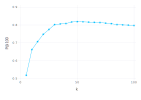

In [18]:
plot(x = ks, y = res, Guide.xlabel("k"), Geom.line, Geom.point, Guide.ylabel("P@100"))

In [19]:
val, idx = findmax(res)
best_k = ks[idx]
val, best_k

(0.8185742950681181, 50)

In [20]:
@btime lsa(dtm, best_k);
Θ = lsa(dtm, best_k)

  362.108 ms (889 allocations: 18.21 MiB)


9469×50 Array{Float32,2}:
 0.556383   0.119262    -0.216741    0.107376    …   0.0949617    0.0468106 
 0.55604   -0.278343     0.266369    0.128456       -0.00424598   0.00206203
 0.606649  -0.191486    -0.198241   -0.215317       -0.00823331   0.04678   
 0.403288   0.0512959    0.0980453   0.0175919      -0.00197874  -0.0138481 
 0.484559   0.0597882   -0.114735    0.115437       -0.114504     0.00115886
 0.679468   0.127389    -0.216413    0.320952    …  -0.0479174   -0.0509229 
 0.636923  -0.0350432   -0.0925089   0.115079       -0.055867    -0.046153  
 0.4236     0.420304     0.0160769  -0.00396378     -0.0688229    0.00880294
 0.640846  -0.0138822   -0.19748     0.0671226      -0.117208     0.11177   
 0.381548   0.00839738  -0.119256    0.0372298      -0.168065     0.395184  
 0.512611   0.0590099   -0.21977    -0.0589218   …  -0.0380119   -0.151306  
 0.381286   0.176115    -0.300532    0.0724993       0.134599     0.0757511 
 0.520149   0.048878    -0.0778504  -0.125733     

In [21]:
using UMAP
using Distances: CosineDist
embedding = umap(Float64.(Θ'), 2, n_neighbors = 20, metric = CosineDist())

2×9469 Array{Float64,2}:
  2.89324  -3.13663  -5.18858  -6.91754  …  -0.895963  -5.85141  -4.79703
 -5.08369  -2.01195   1.83901  -3.39519      4.66319    2.56451  -0.59986

In [24]:
p = plot(x = embedding[1,:],
         y = embedding[2,:],
         color = newsgroups["target_names"][1 .+ newsgroups["target"]],
         Guide.xticks(ticks = nothing),
         Guide.yticks(ticks = nothing), 
         Guide.xlabel(nothing), 
         Guide.ylabel(nothing))
import Cairo, Fontconfig

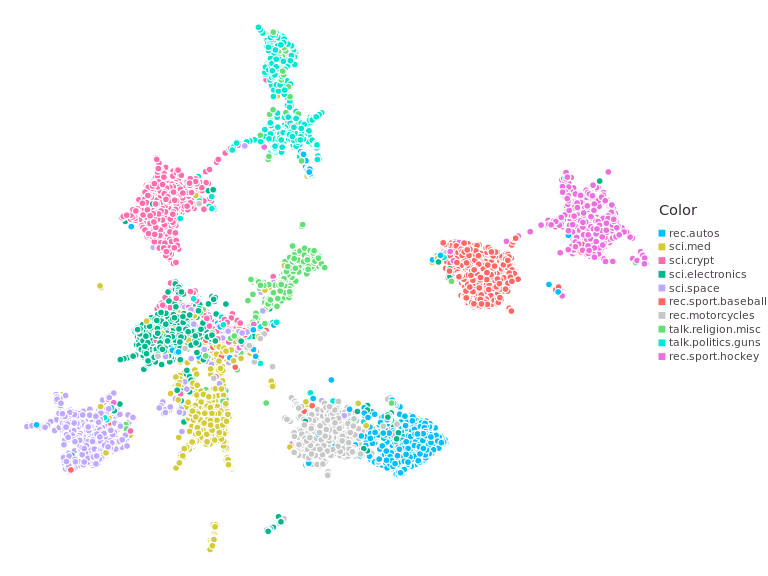

In [25]:
draw(PNG(8inch,6inch), p);